In [1]:
import os
import numpy as np
import pandas as pd
import re
from scipy.io import wavfile
import heapq

import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy.signal import find_peaks
from sklearn.preprocessing import normalize
from scipy.signal import savgol_filter

import statsmodels.api as smt
import seaborn as sns
from scipy.signal import spectrogram

import HackFunctions as hf

In [2]:
# Training
# Input: one dimensional time series of length T, sampling frequency, k number of peaks
# Output: k parameters -> mean and std

# Predicting
# Input: one dimensional time series of length T / k and parameters
# Output: True anomaly or False normal

In [3]:
# Synthetic Data

syn_sounds, syn_files = hf.createdict("synthetic")

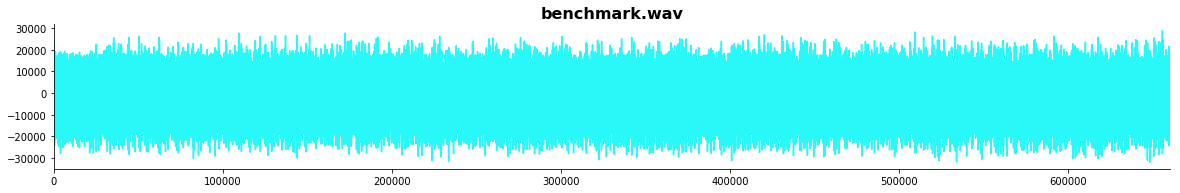

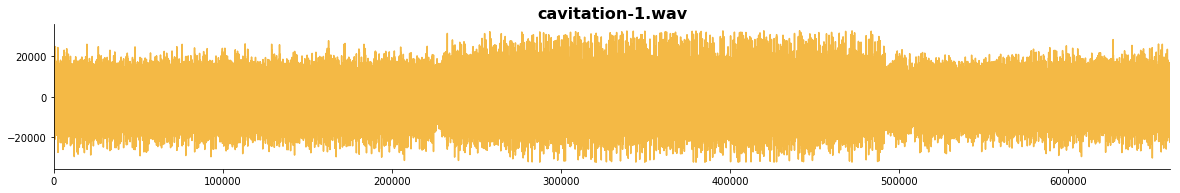

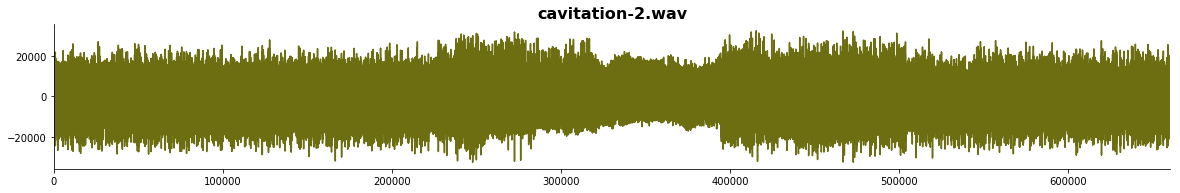

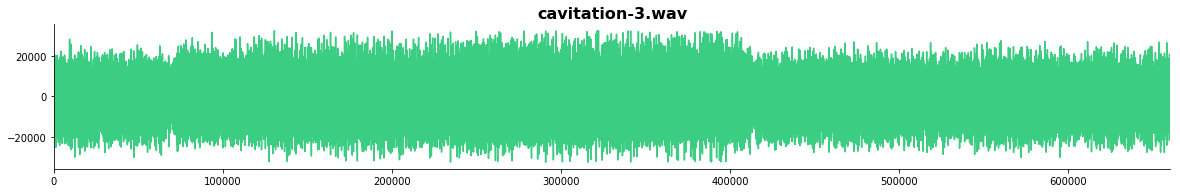

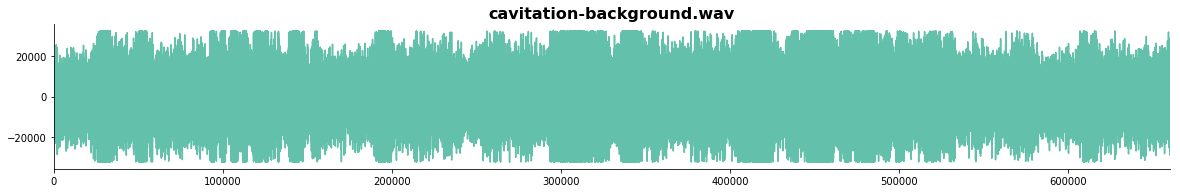

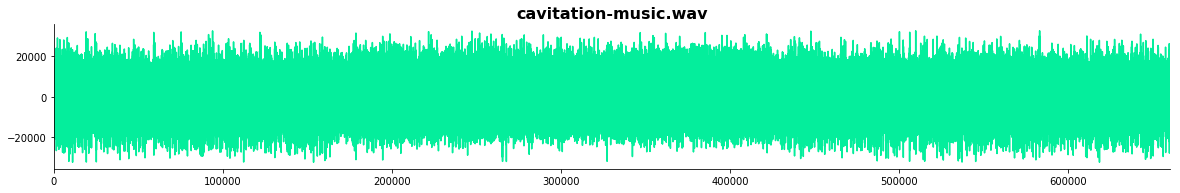

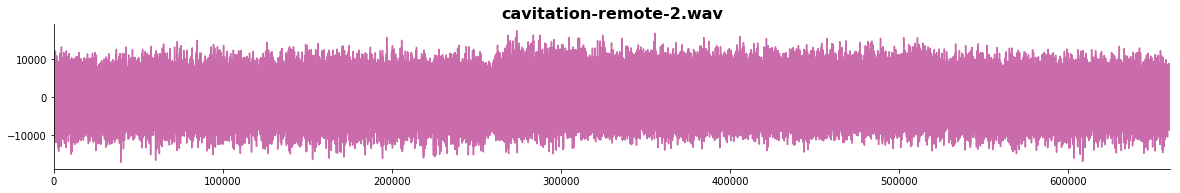

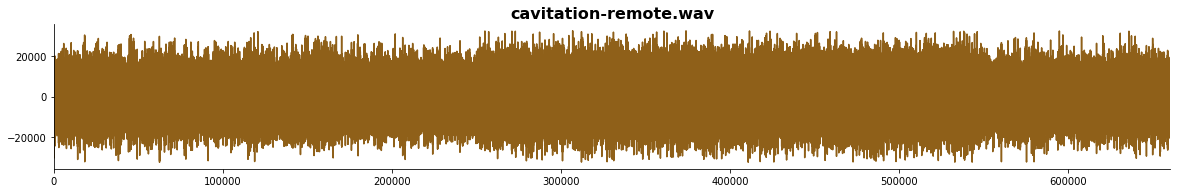

In [4]:
hf.plotsounds(syn_sounds)

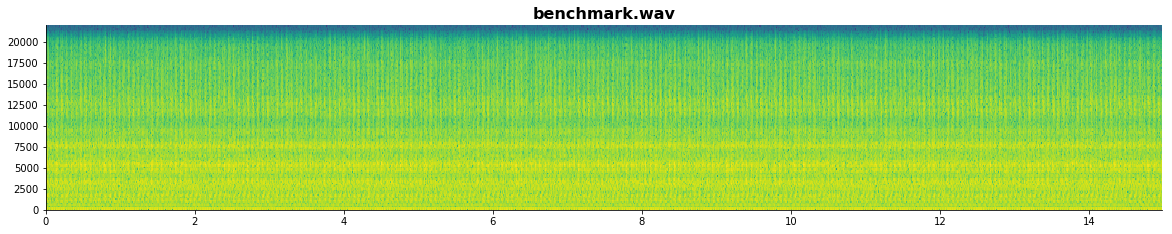

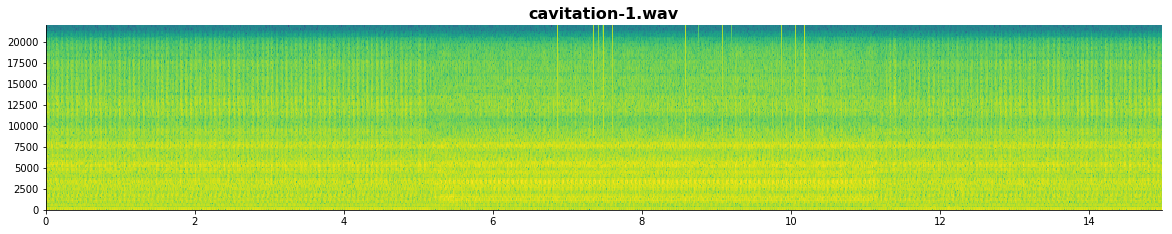

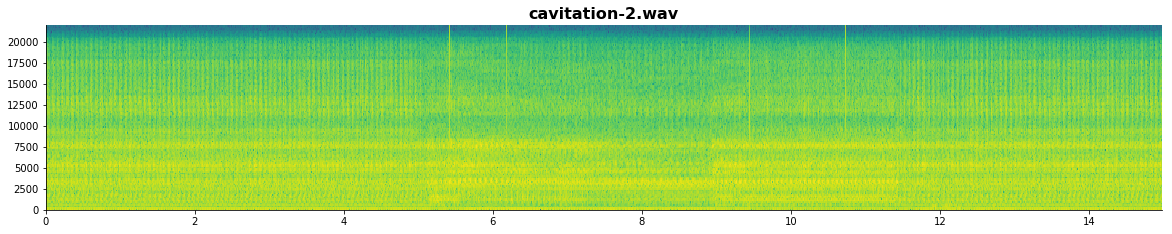

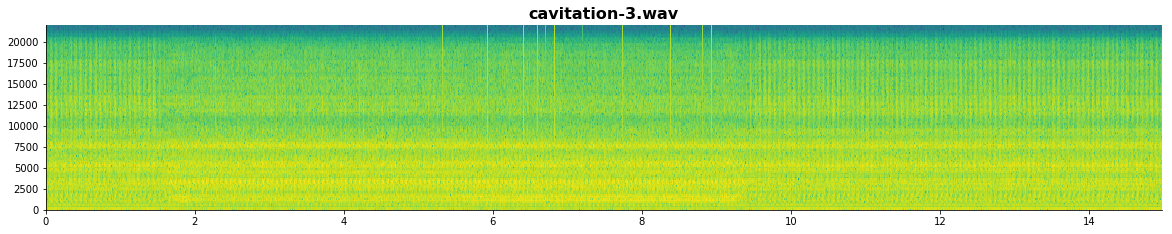

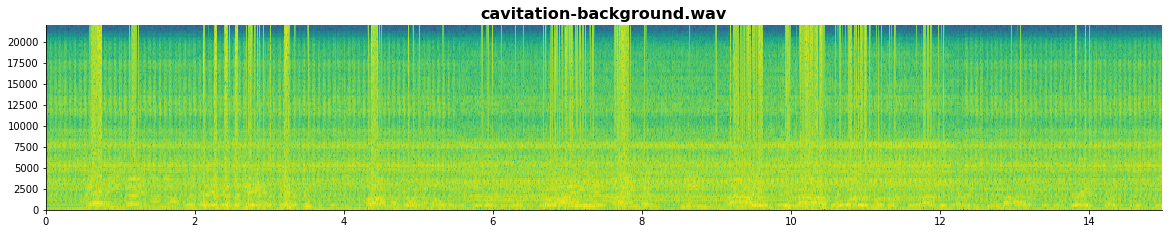

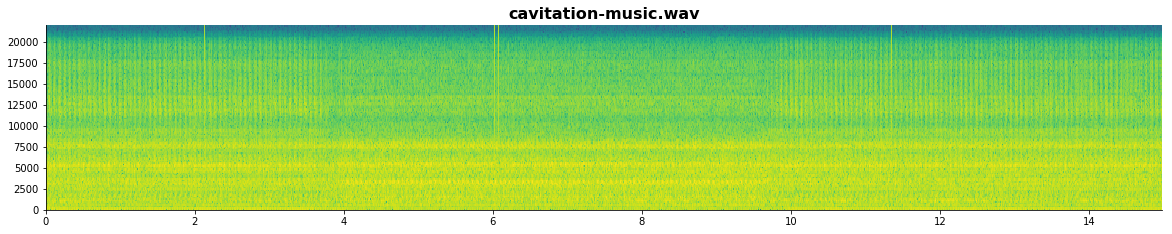

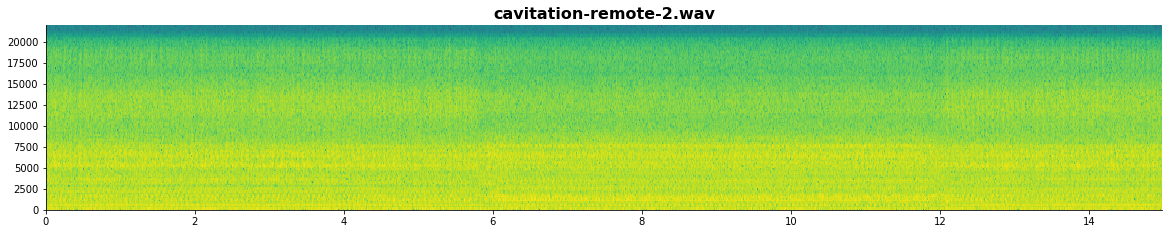

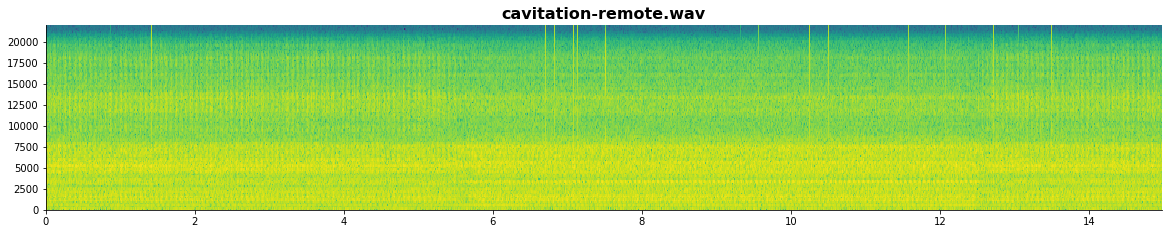

In [11]:
hf.plotspecs(syn_sounds)

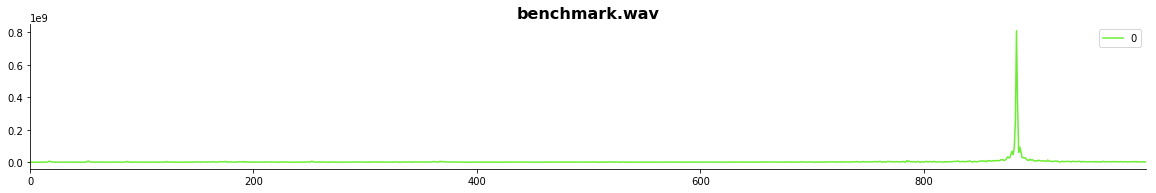

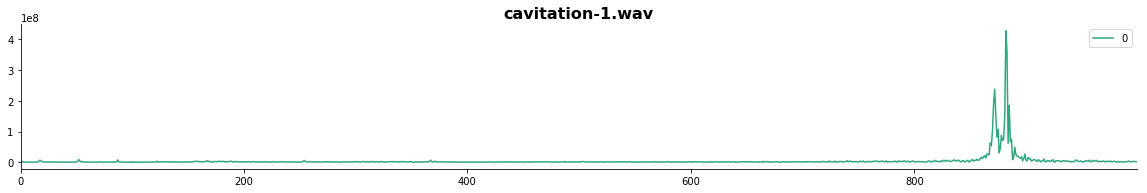

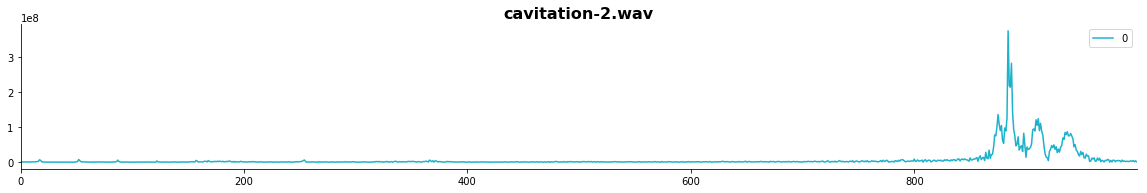

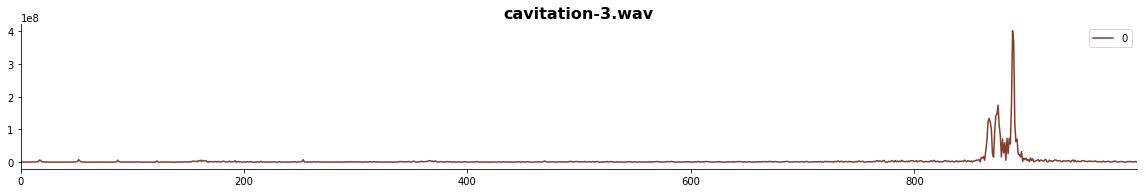

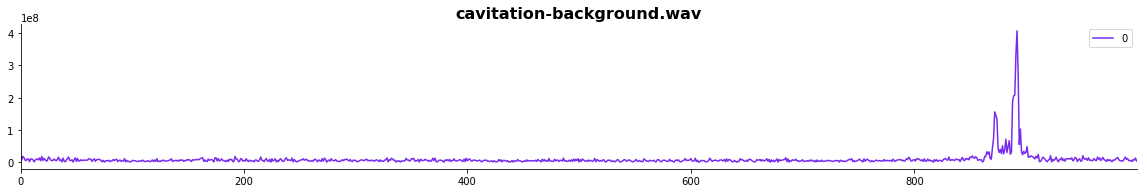

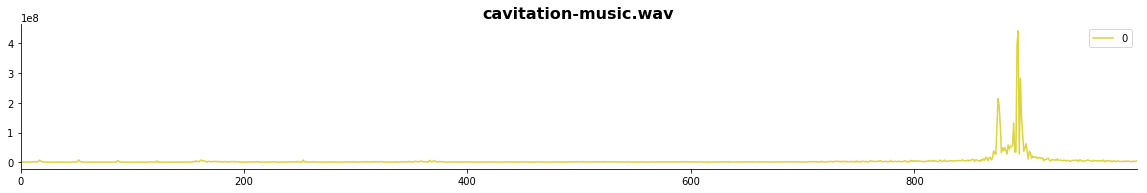

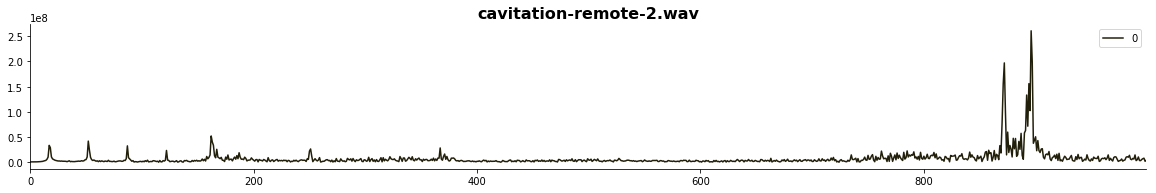

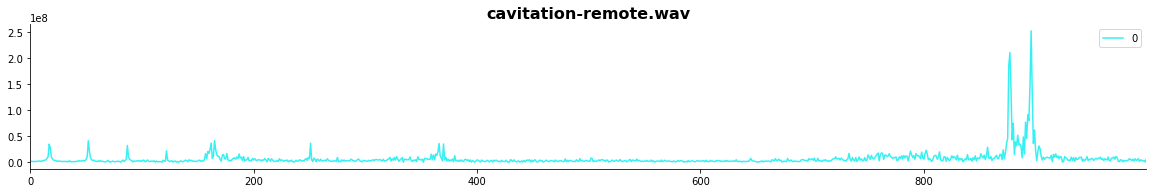

In [133]:
hf.plotfreq(syn_sounds, 1000, False, True)

In [134]:
subsets_benchmark = hf.rand_crops(syn_sounds['cavitation-1.wav'][1][0], 50000, 100)

In [148]:
subsets_benchmark = hf.seq_crops(syn_sounds['cavitation-1.wav'][1][0], 100)

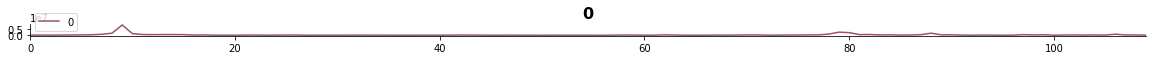

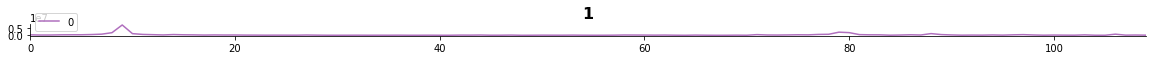

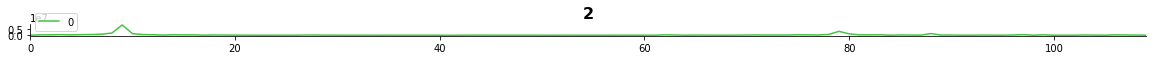

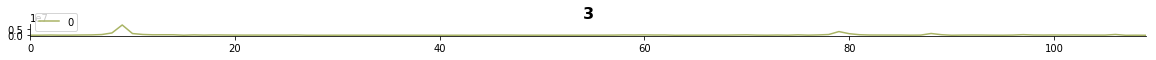

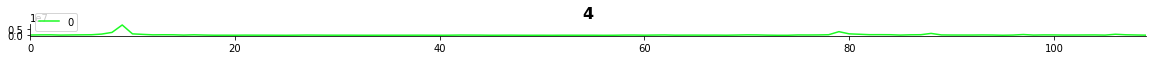

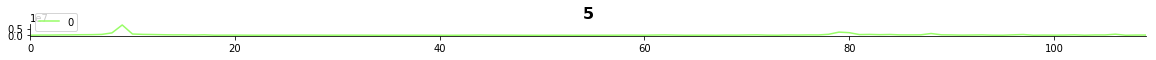

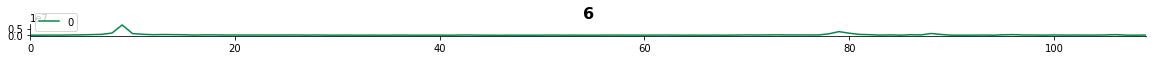

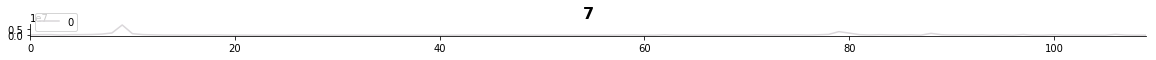

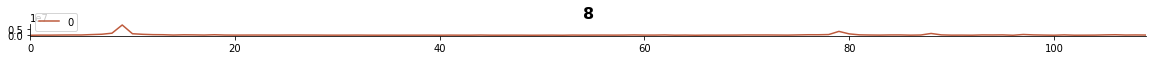

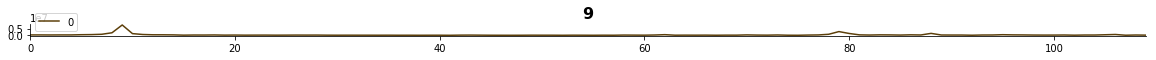

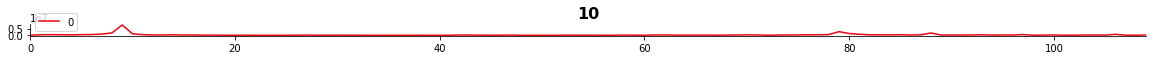

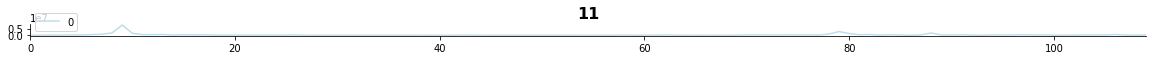

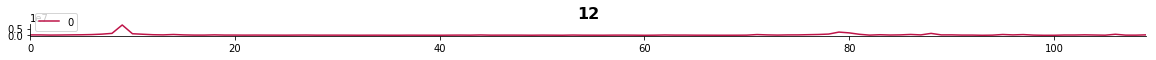

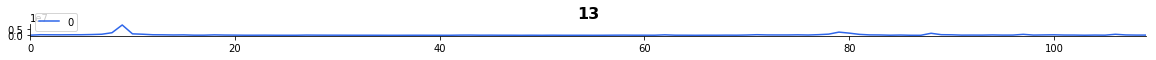

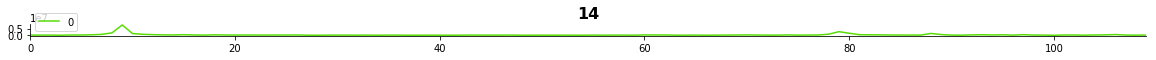

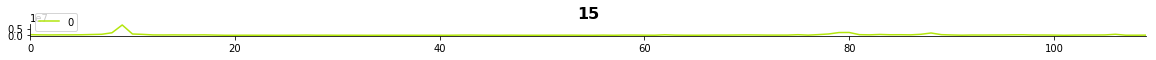

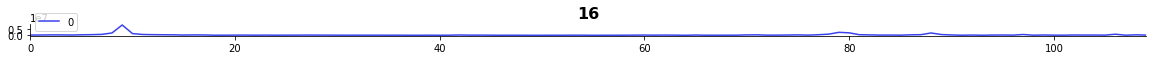

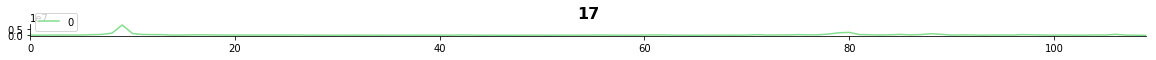

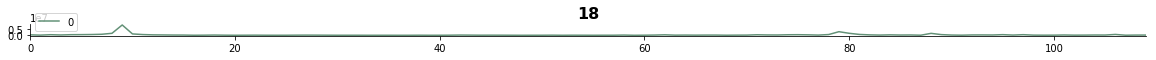

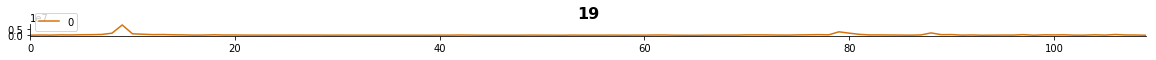

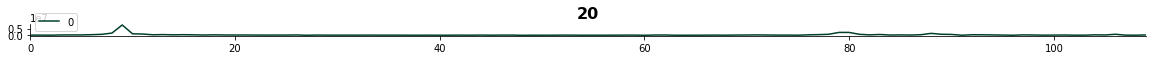

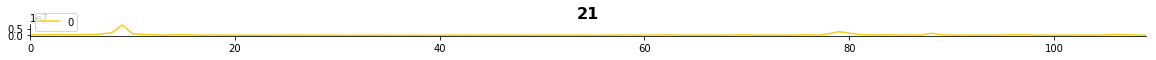

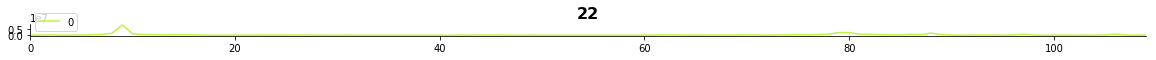

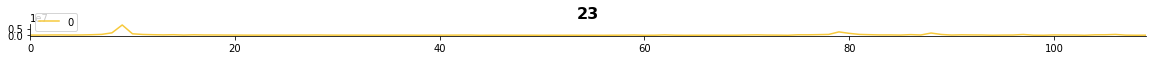

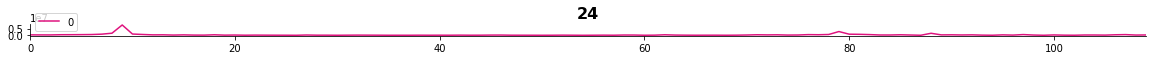

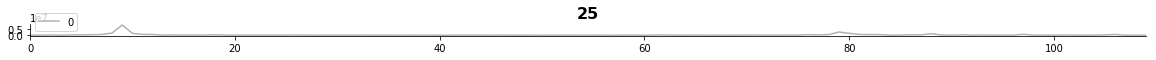

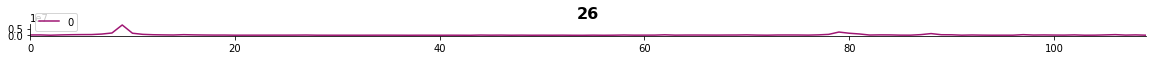

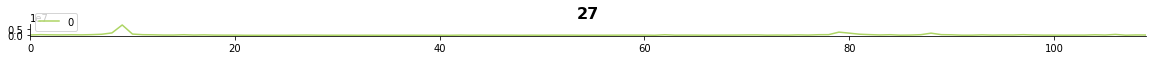

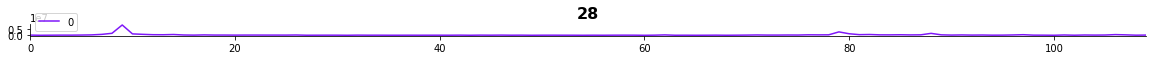

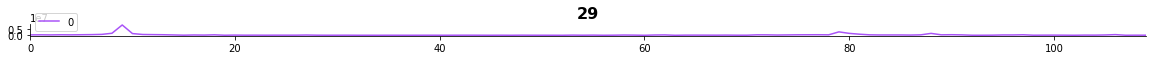

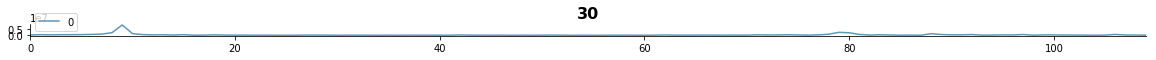

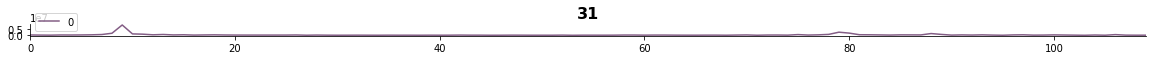

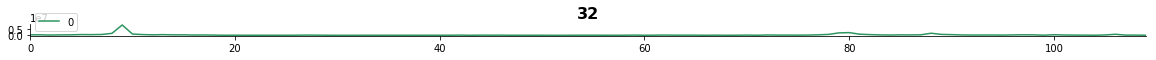

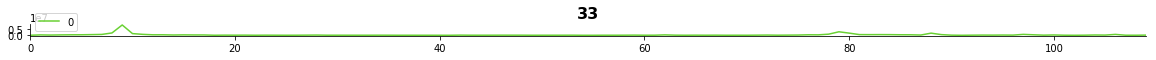

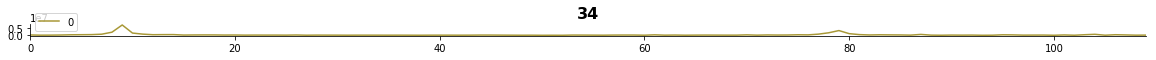

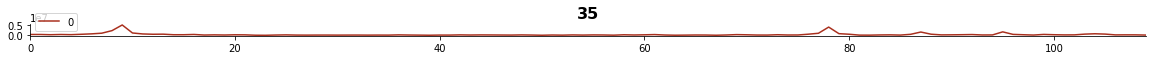

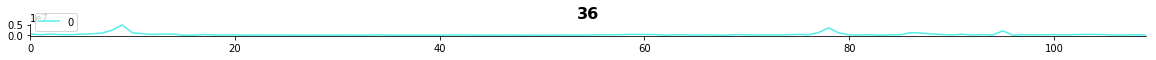

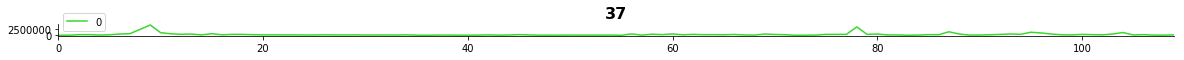

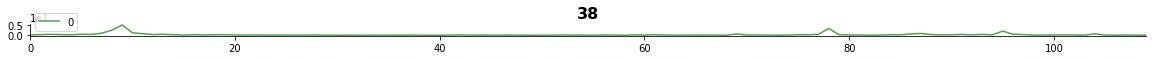

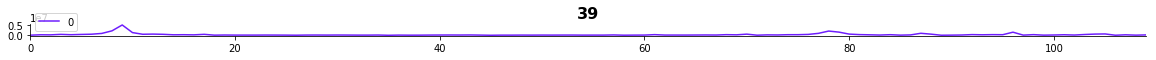

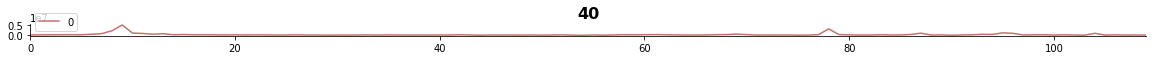

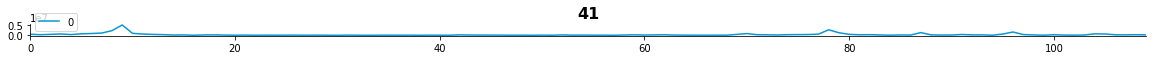

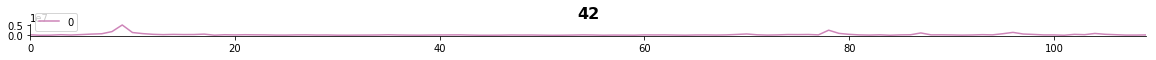

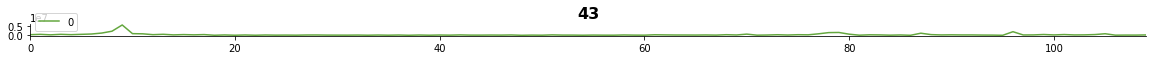

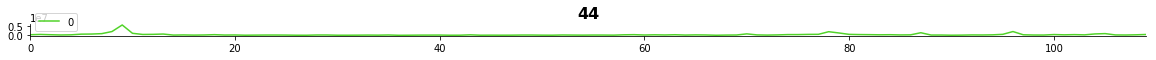

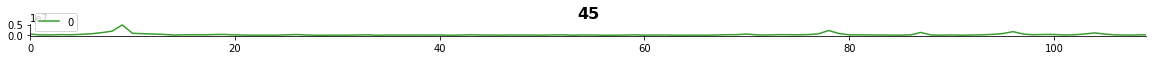

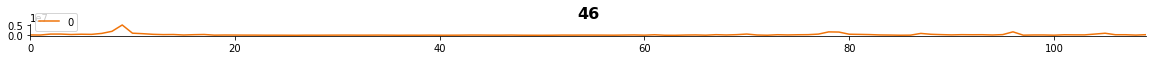

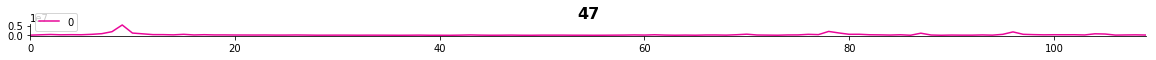

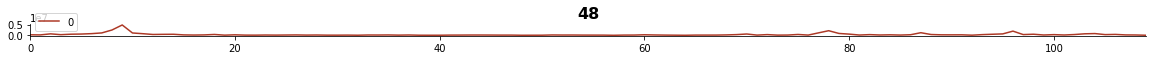

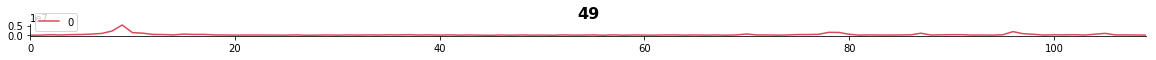

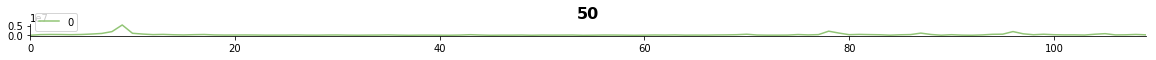

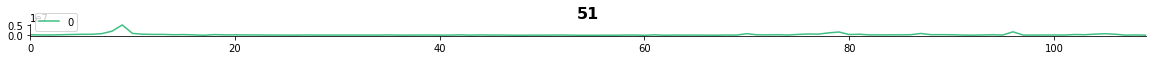

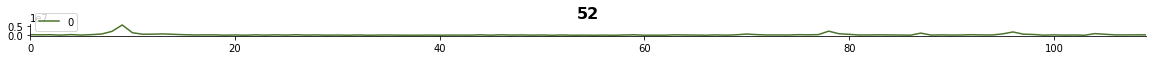

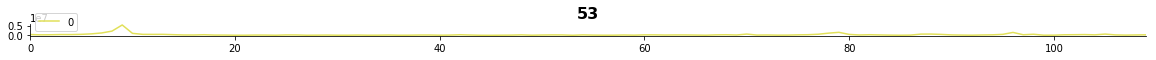

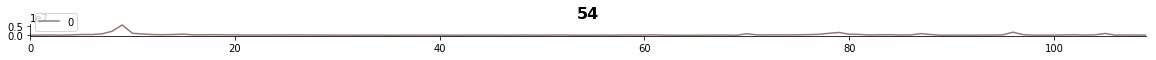

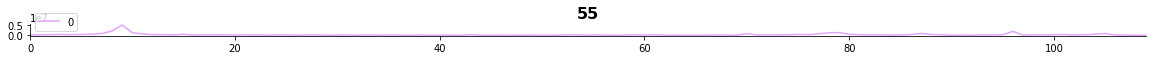

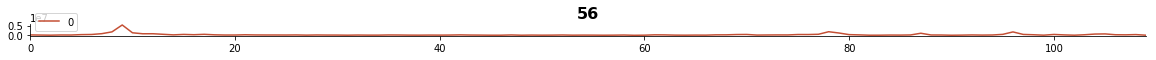

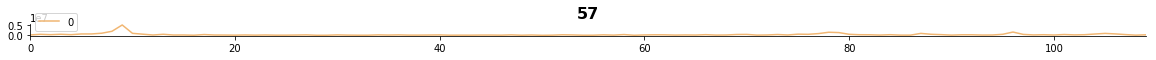

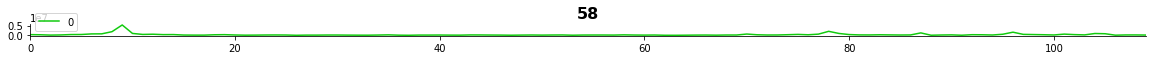

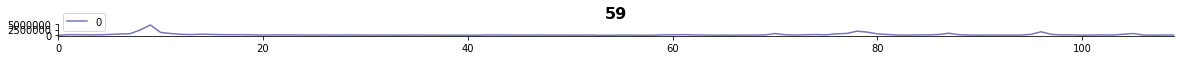

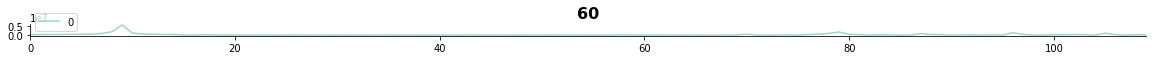

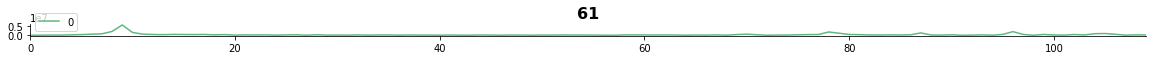

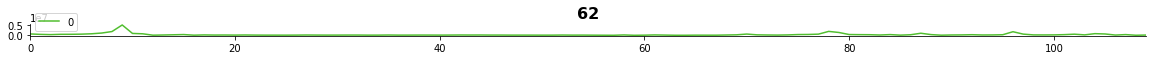

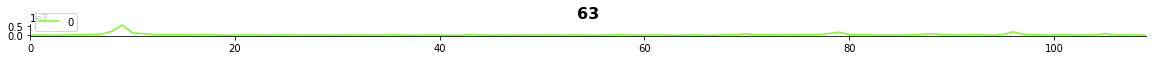

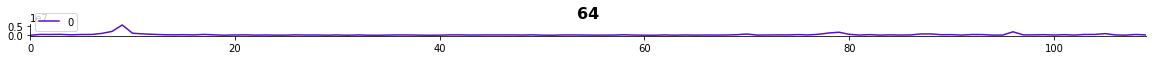

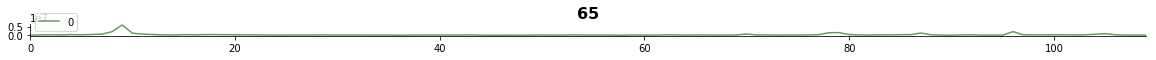

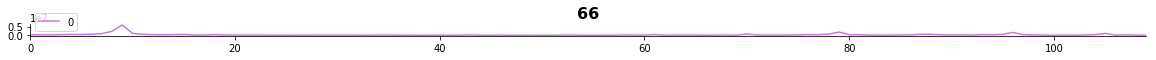

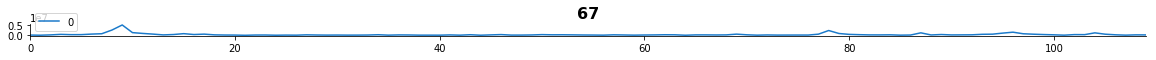

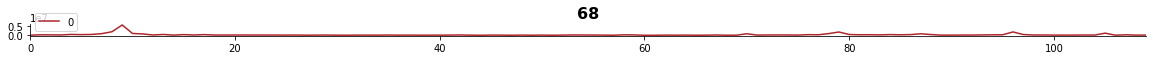

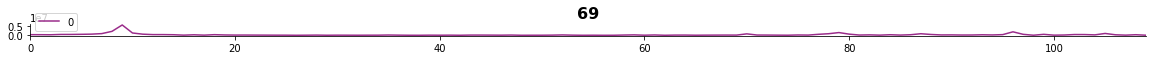

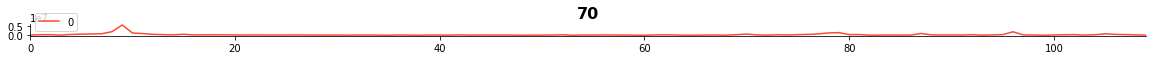

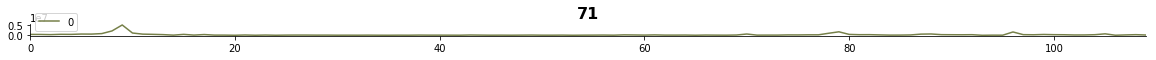

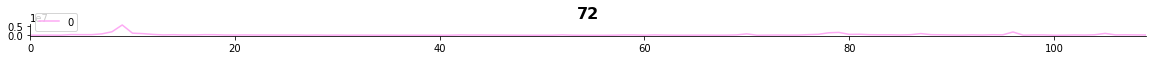

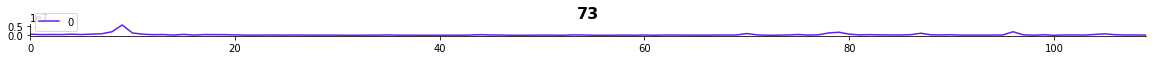

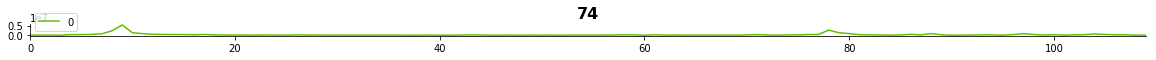

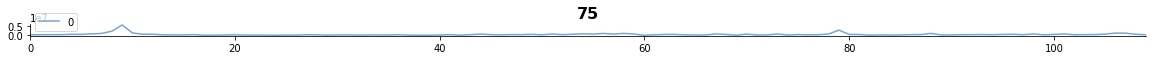

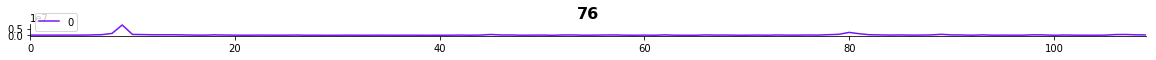

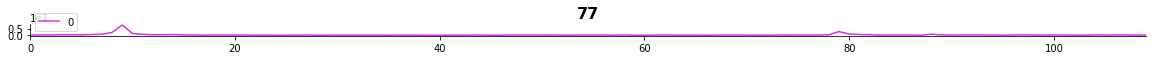

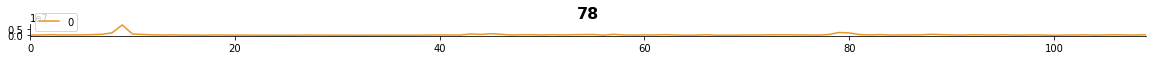

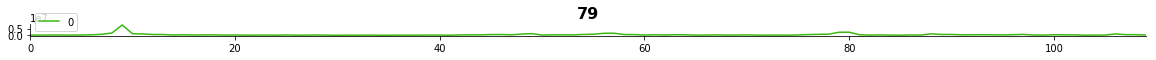

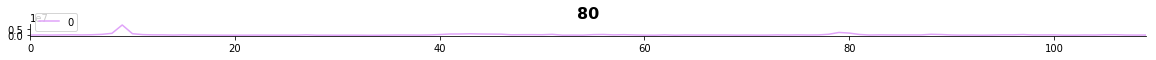

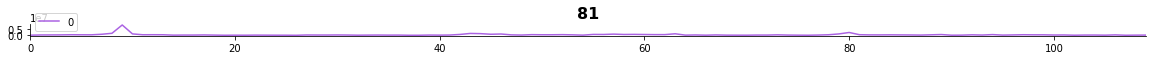

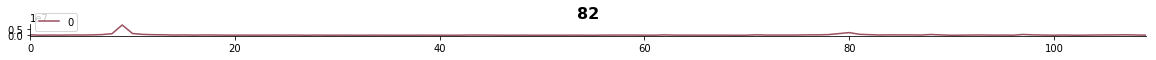

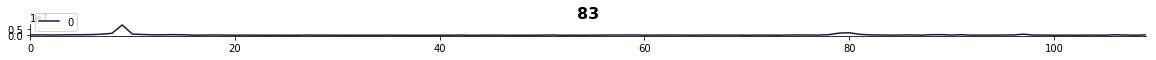

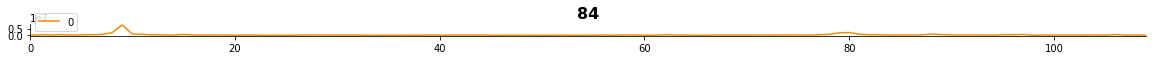

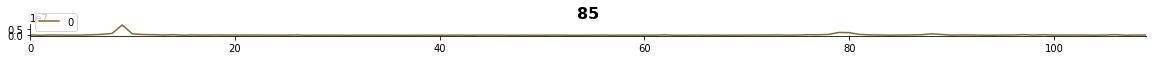

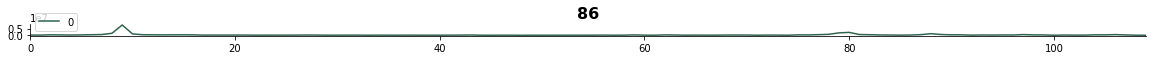

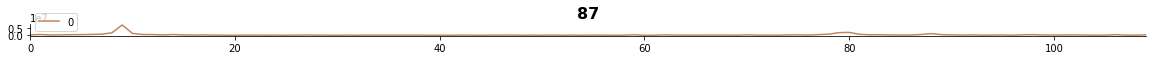

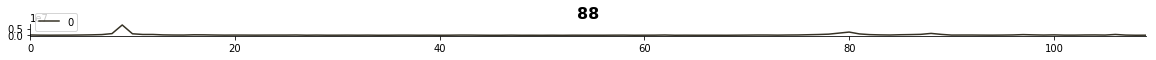

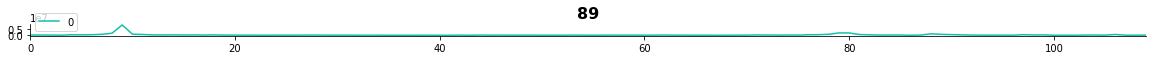

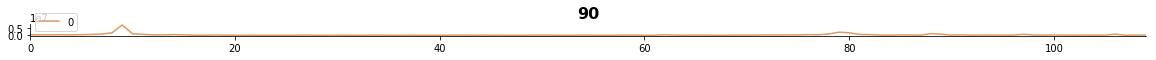

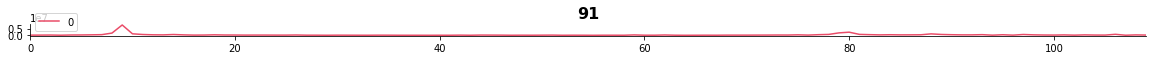

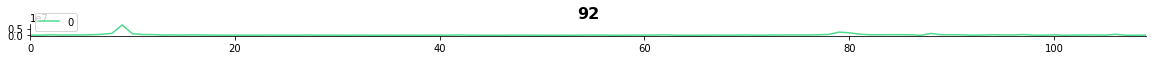

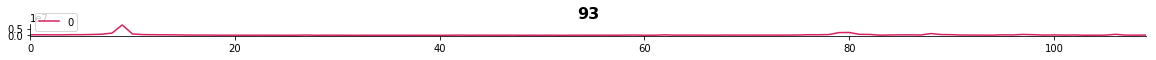

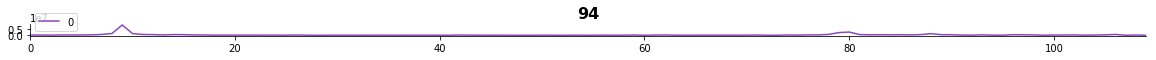

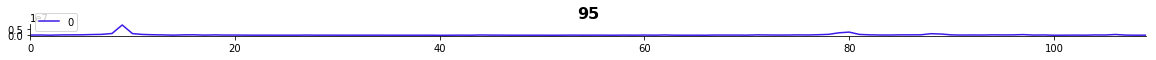

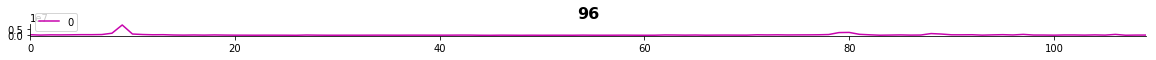

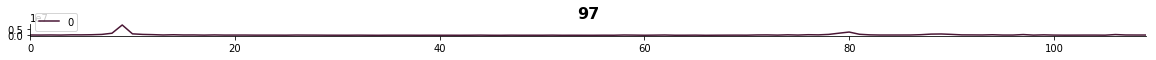

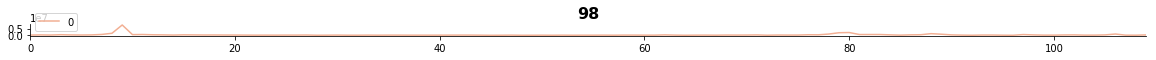

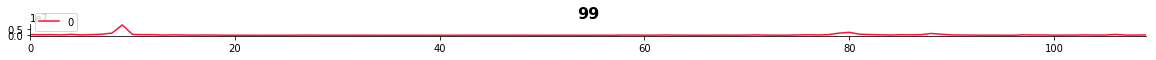

In [149]:
hf.plotfreq(subsets_benchmark, 110, False, True, window = 101)

In [150]:
sample_bench, bench_means, bench_stds = hf.build_dist(subsets_benchmark, window = 51, num_peaks = 4)

In [128]:
def detect_outlier(ts, dist_means, dist_stds, window, alpha = 0.0, threshold = 0.5):
    k = int(len(ts) / window)
    subsets = hf.seq_crops(ts, k)
    samples, means, stds = hf.build_dist(subsets, num_peaks = dist_means.shape[0])
    outputs = []
    for col in range(dist_means.shape[0]):
        high_bound = dist_means[col] + (3 * dist_stds[col])
        low_bound = dist_means[col] - (3 * dist_stds[col])
        column = samples[:, col]
        out = (column > high_bound) + (column < low_bound)
        outputs.append(out)
    outputs = np.sum(np.array(outputs), axis = 0)
    return(outputs >= np.ceil(threshold * dist_means.shape[0]))

In [132]:
detect_outlier(syn_sounds['cavitation-1.wav'][1][0], bench_means, bench_stds, 50000, threshold = 0.25)

array([False, False, False, False,  True,  True, False,  True,  True,
       False, False, False, False])

In [39]:
param = hf.run_train(syn_sounds['benchmark.wav'][1][0], length = 50000, num_peaks = 1)

In [43]:
hf.run_predict(syn_sounds['cavitation-1.wav'][1][0], param)

array([False])

In [142]:
# Import the real data

real_sounds, real_files = hf.createdict("real")

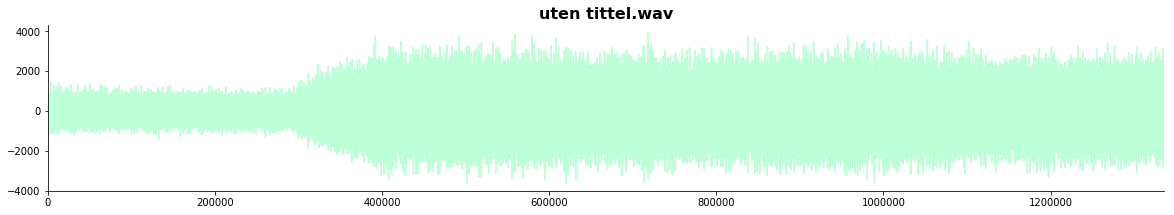

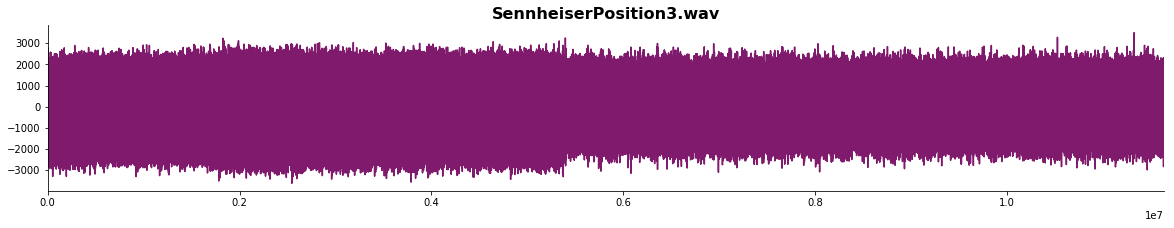

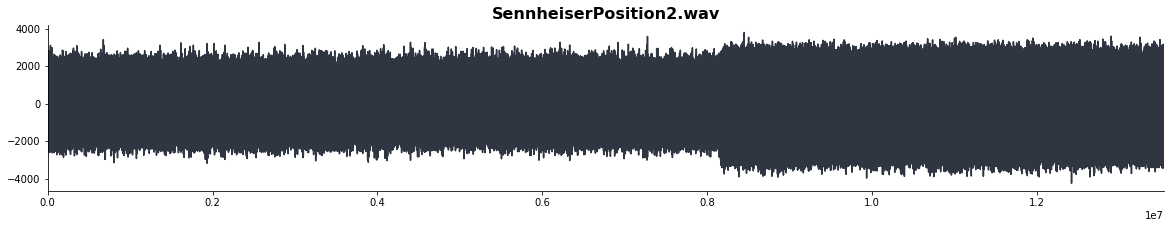

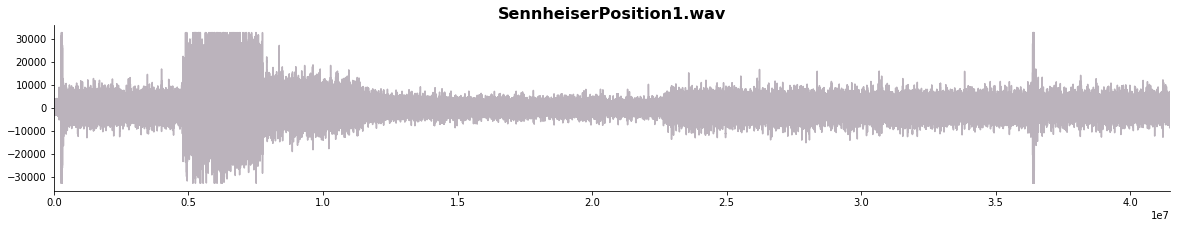

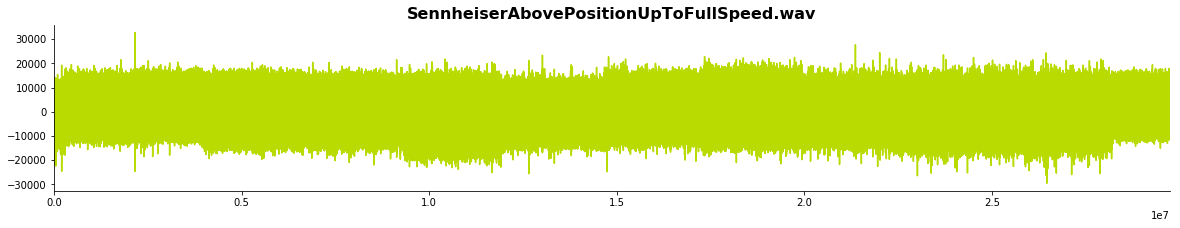

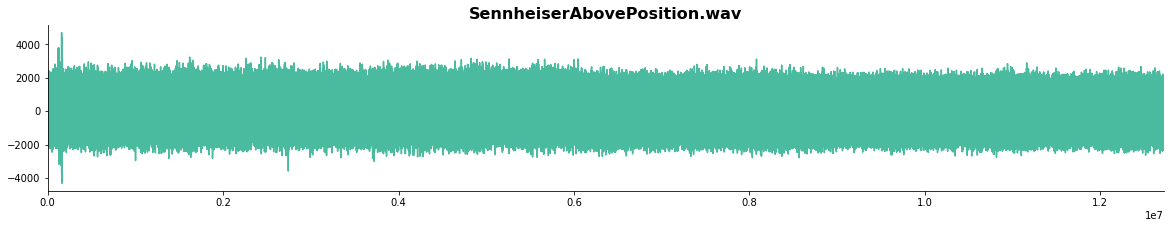

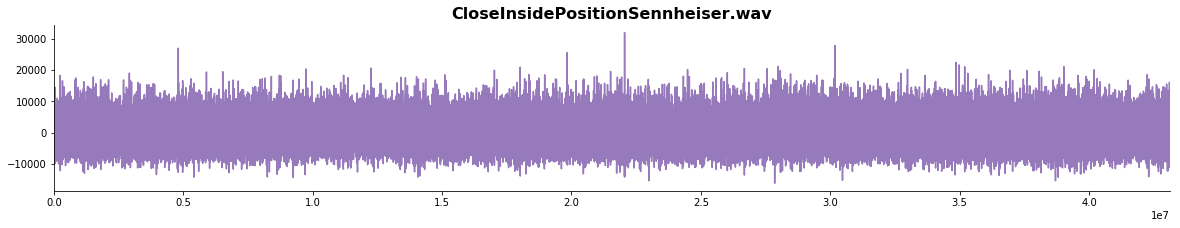

In [143]:
hf.plotsounds(real_sounds)

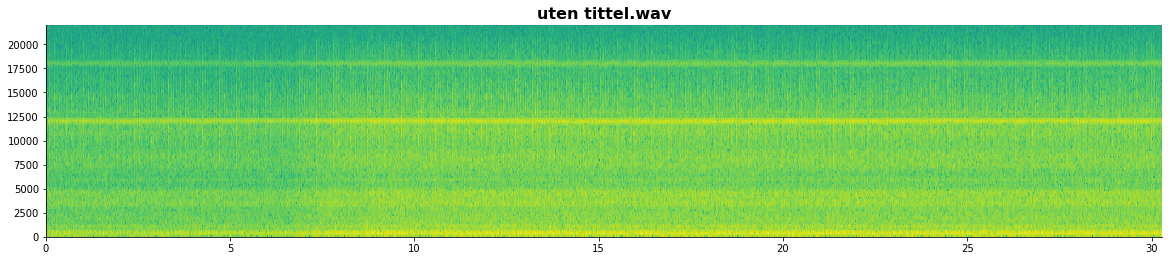

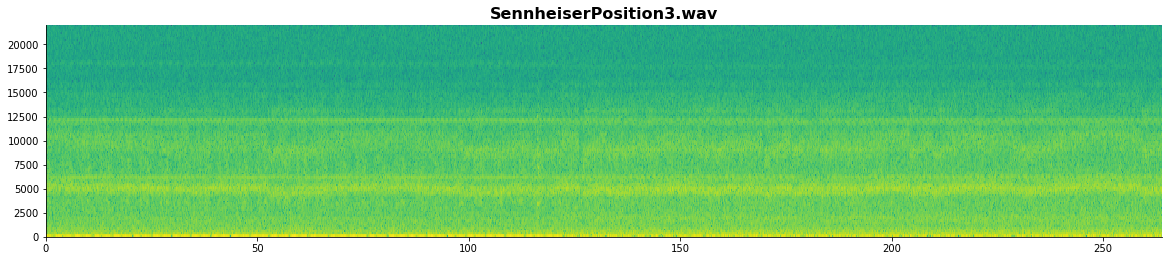

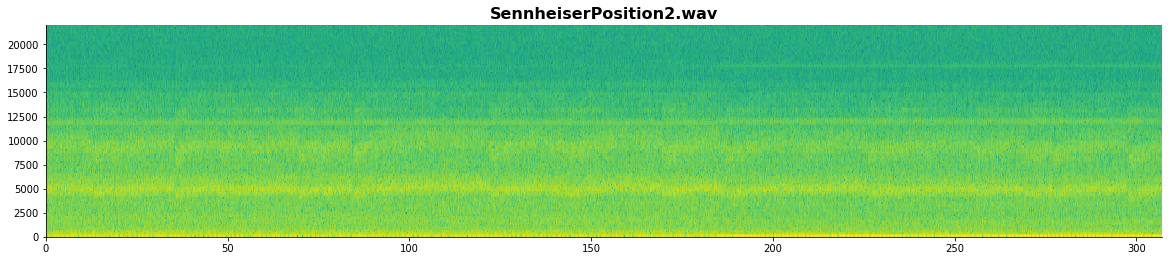

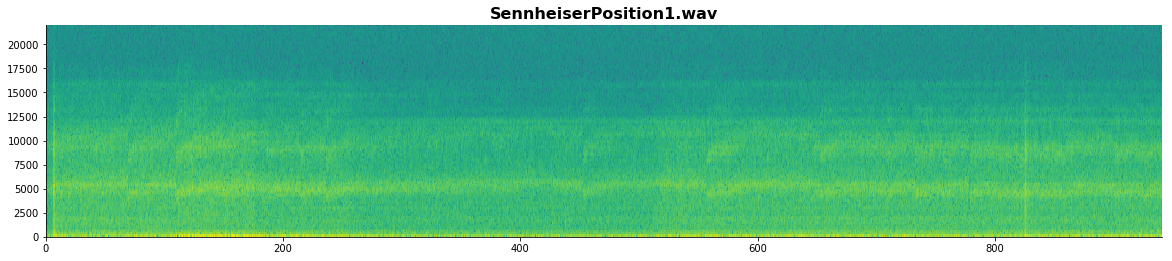

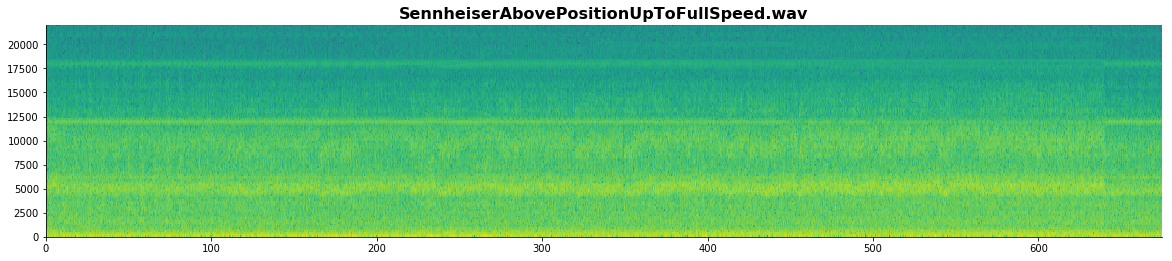

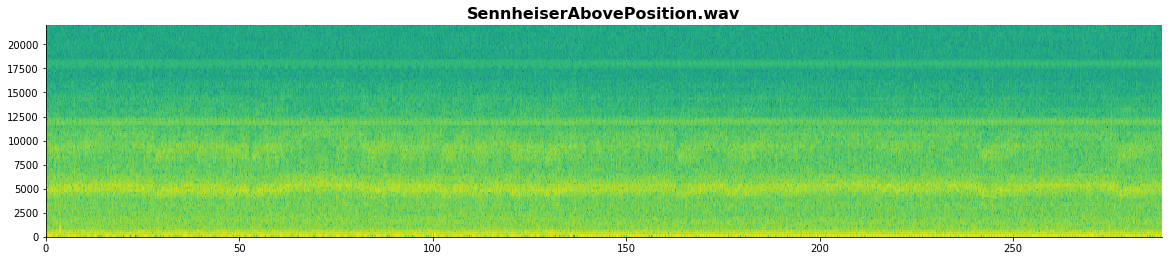

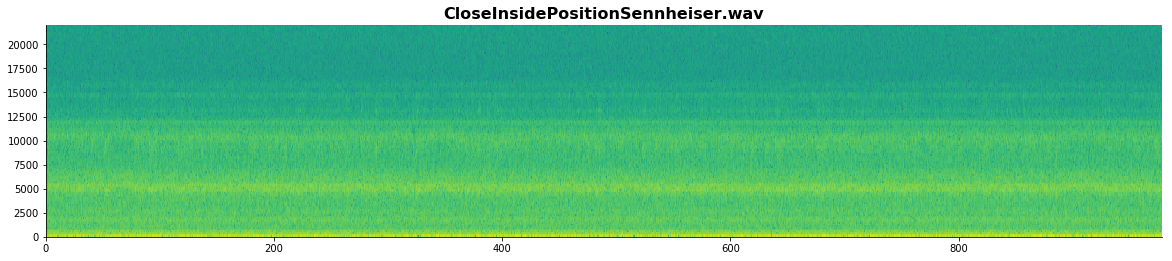

In [144]:
hf.plotspecs(real_sounds)

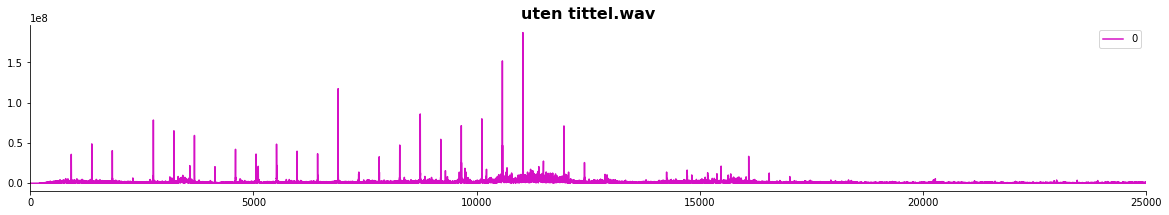

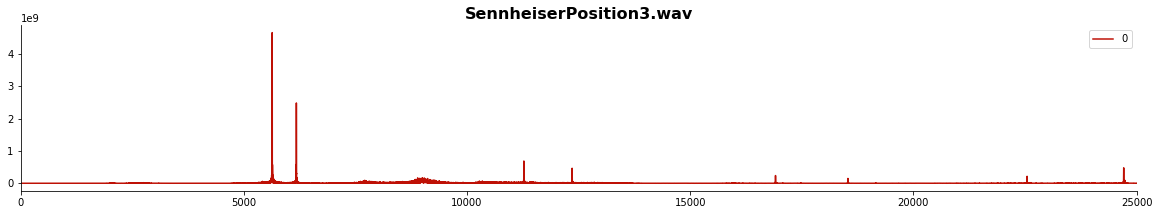

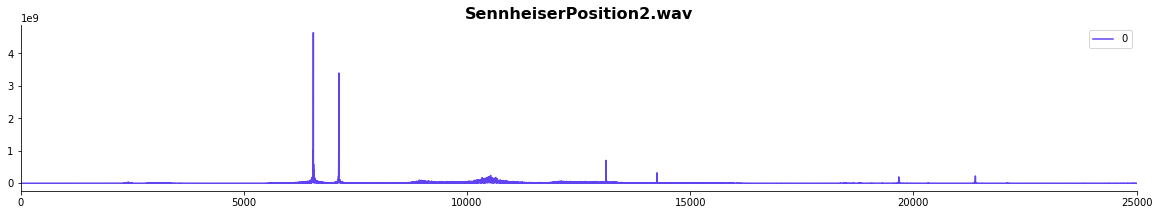

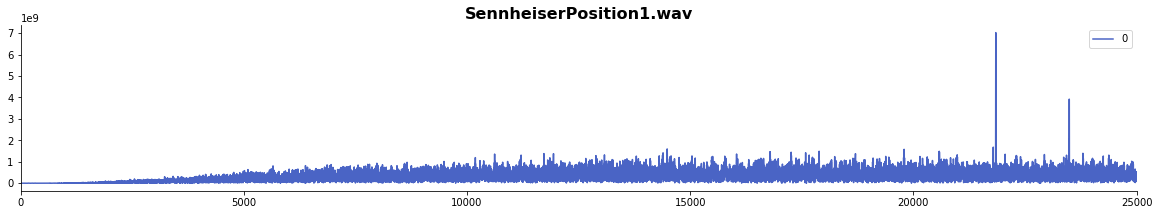

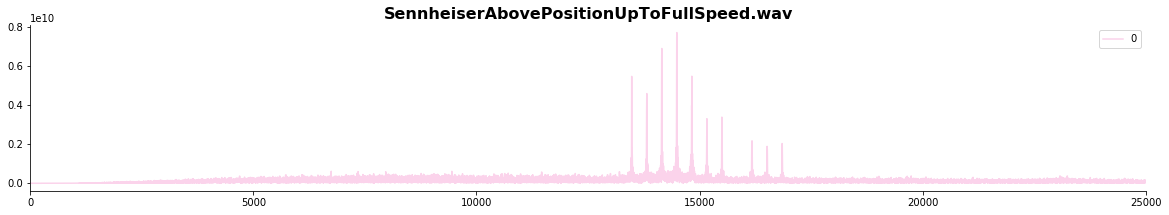

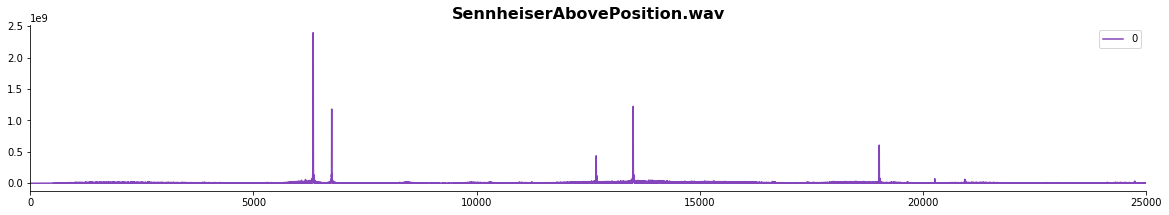

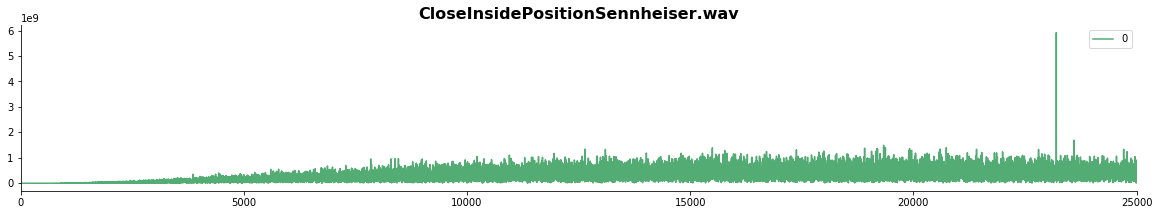

In [145]:
hf.plotfreq(real_sounds, 25000, False, True)

In [146]:
subsets_real = hf.rand_crops(real_sounds['uten tittel.wav'][1][0], 50000, 100)

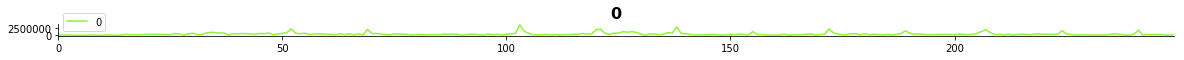

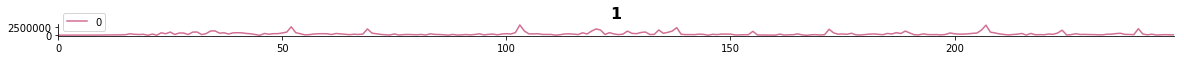

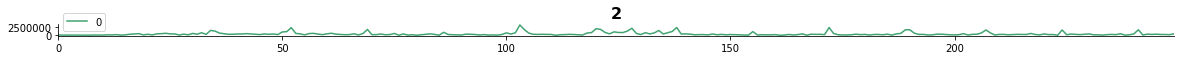

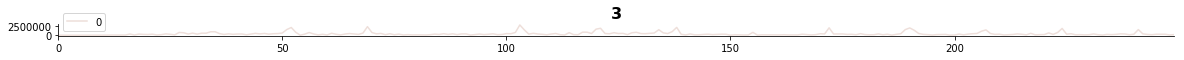

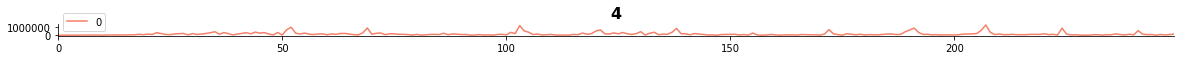

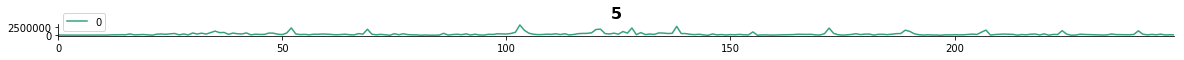

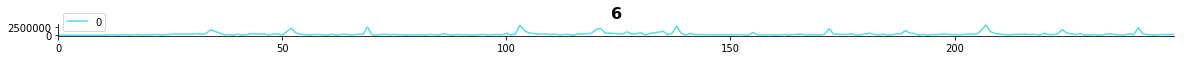

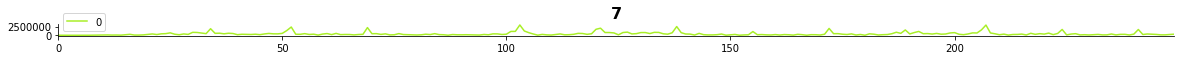

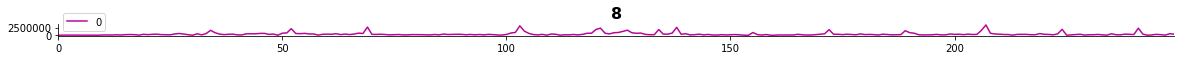

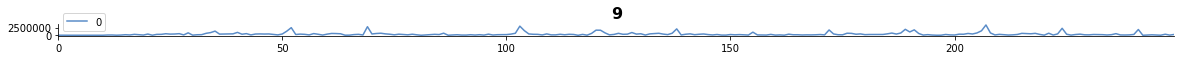

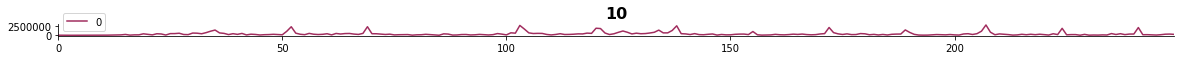

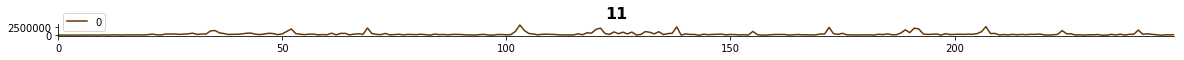

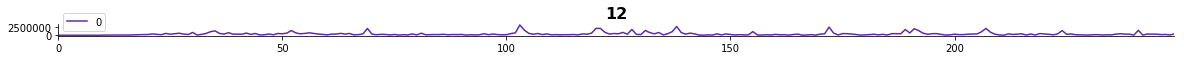

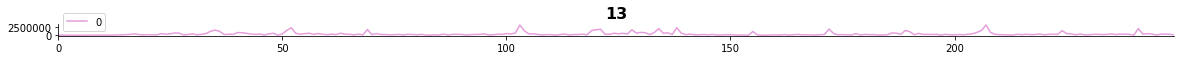

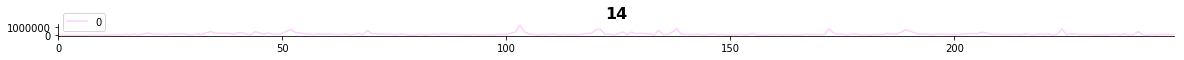

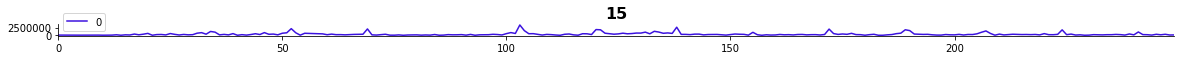

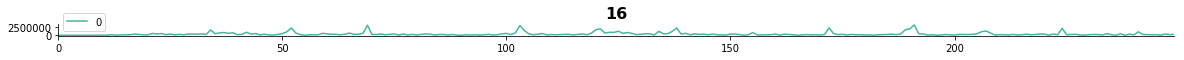

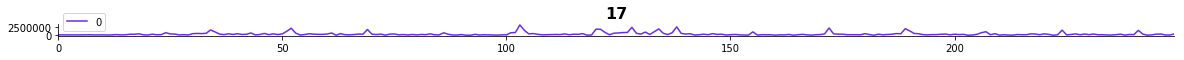

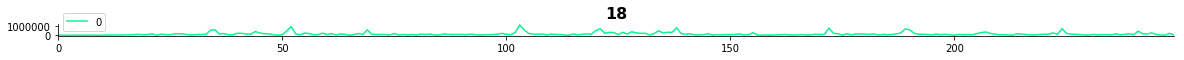

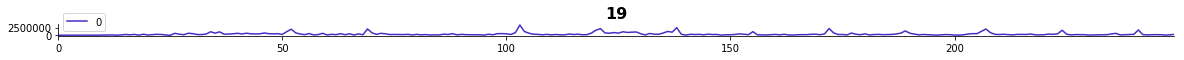

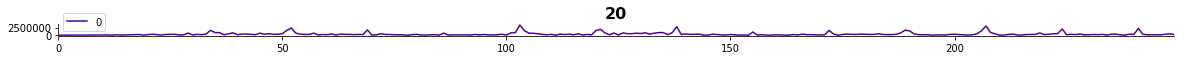

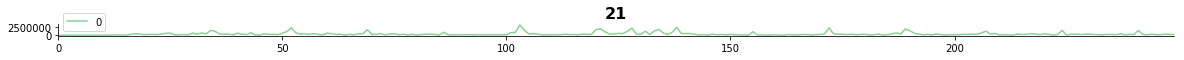

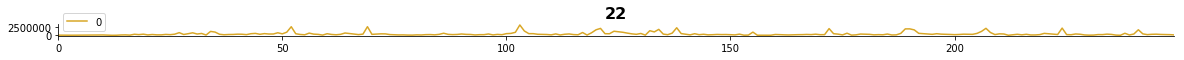

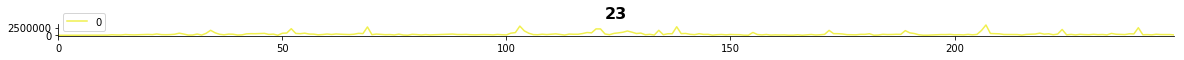

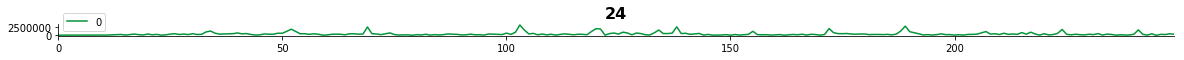

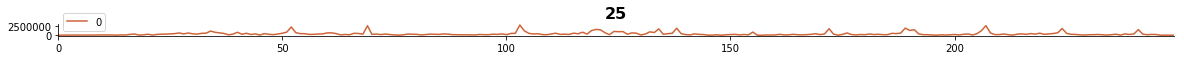

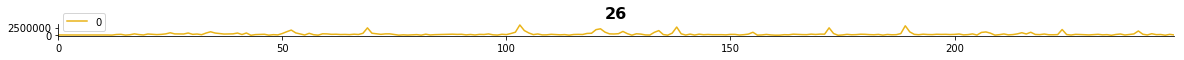

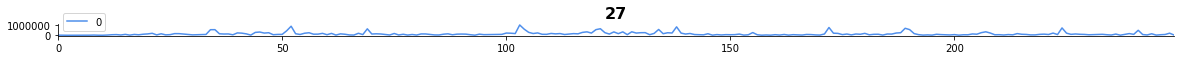

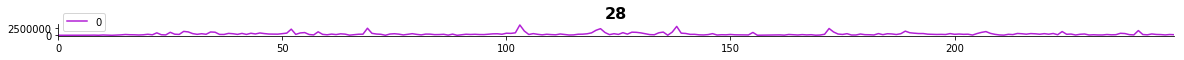

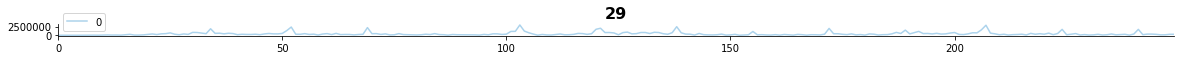

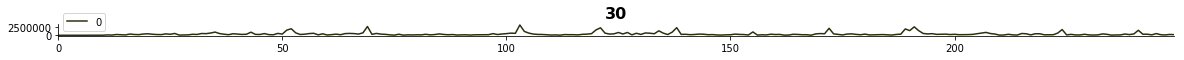

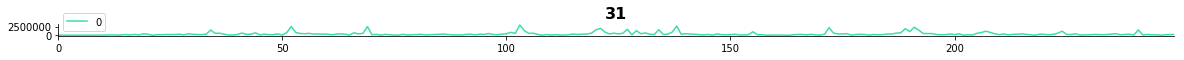

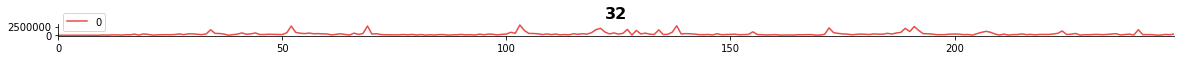

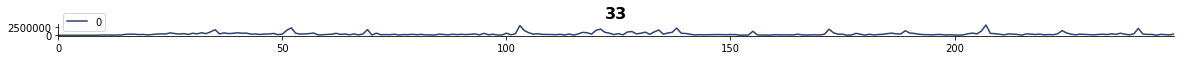

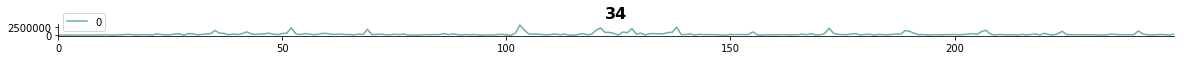

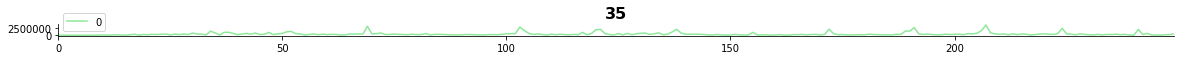

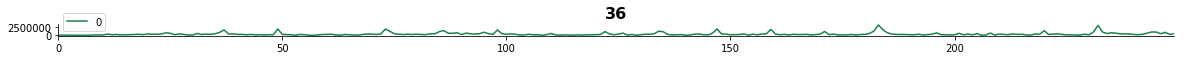

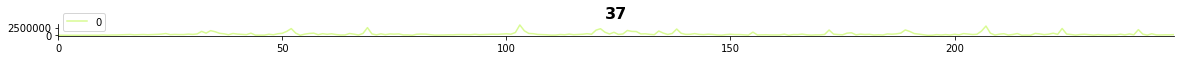

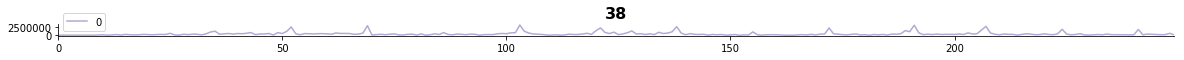

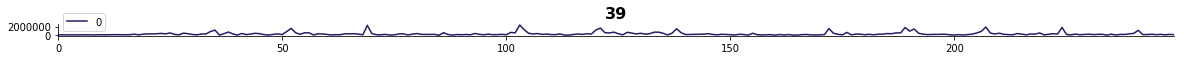

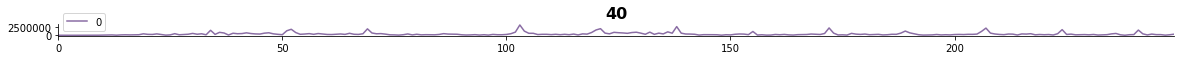

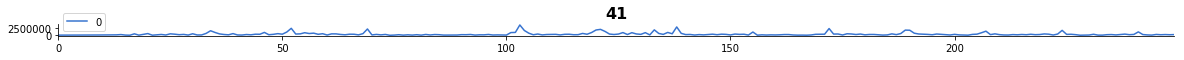

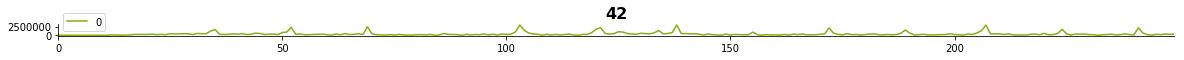

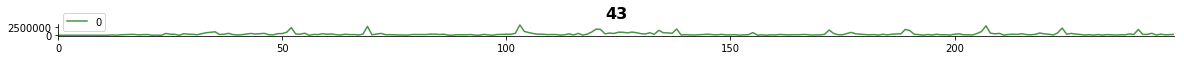

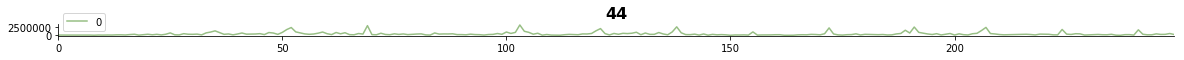

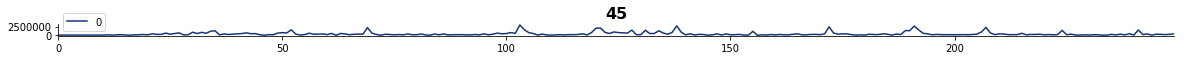

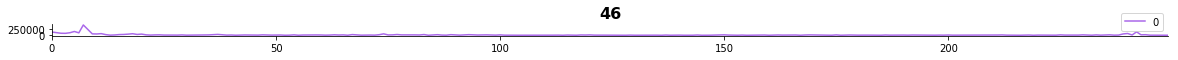

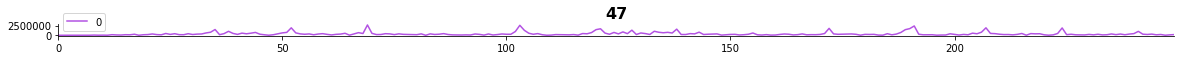

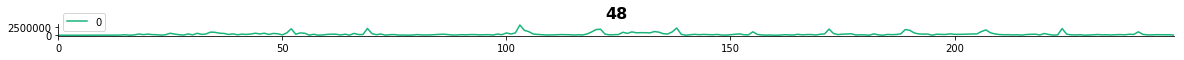

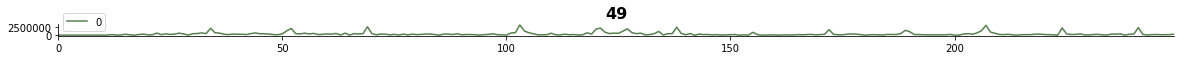

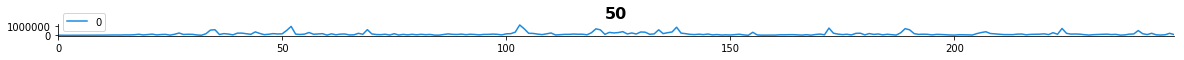

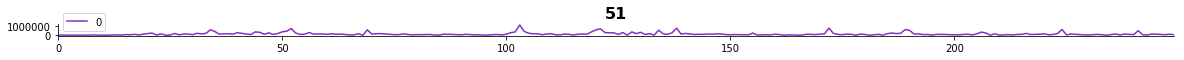

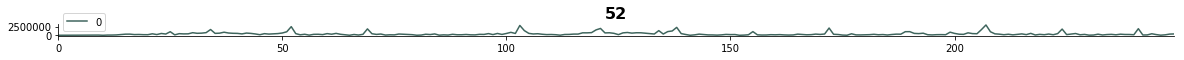

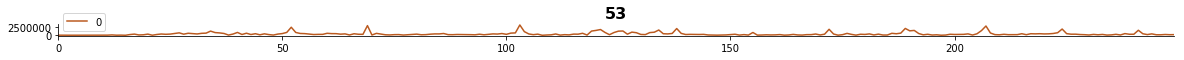

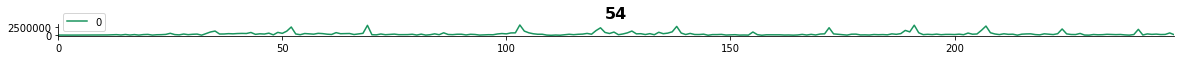

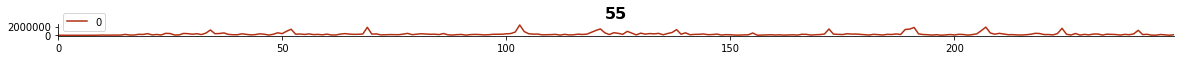

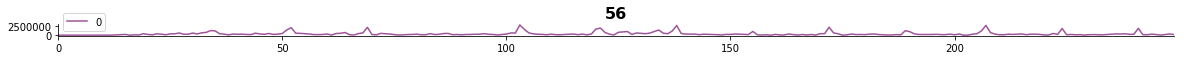

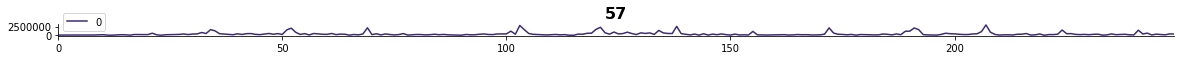

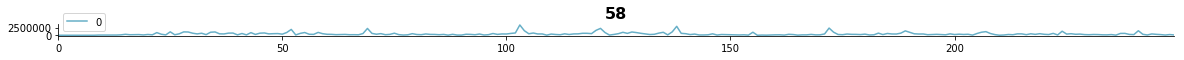

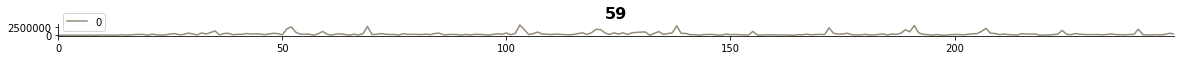

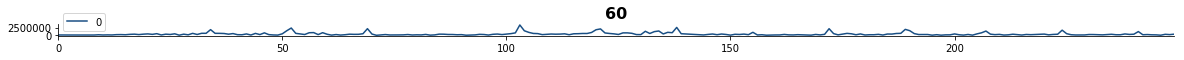

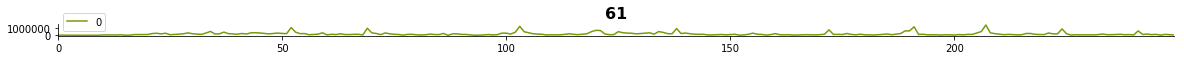

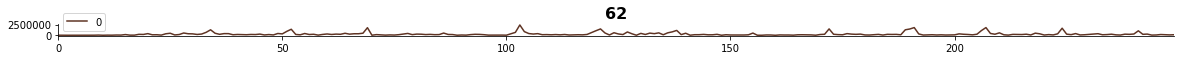

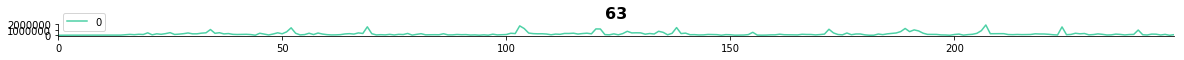

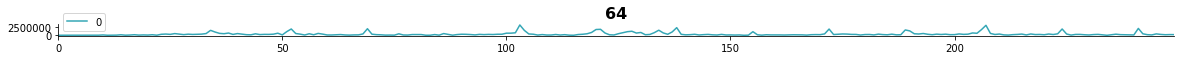

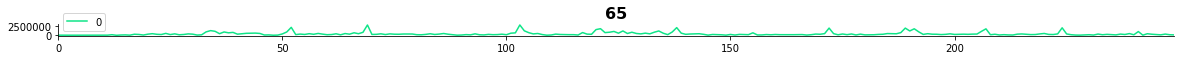

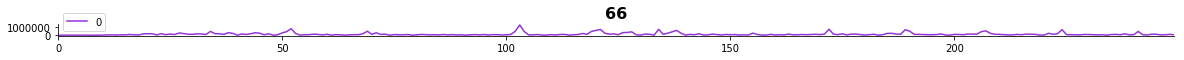

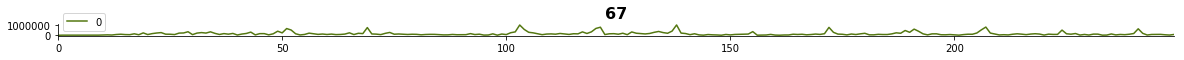

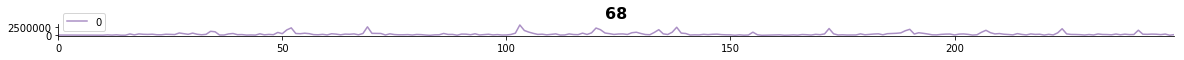

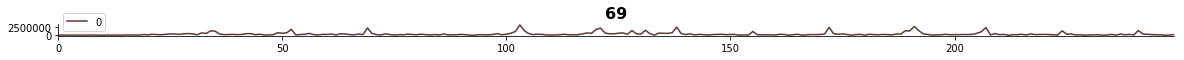

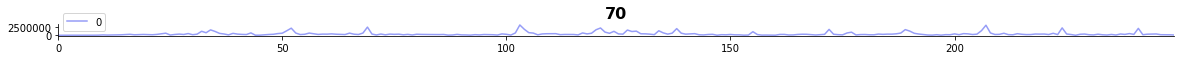

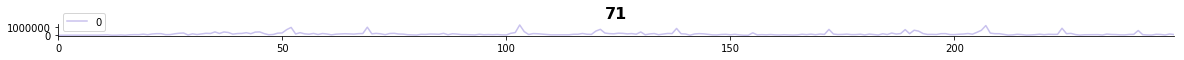

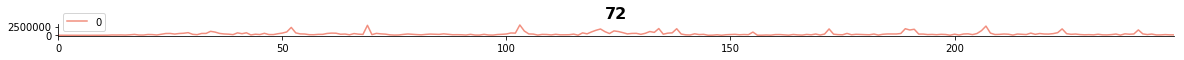

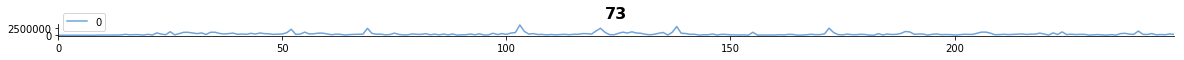

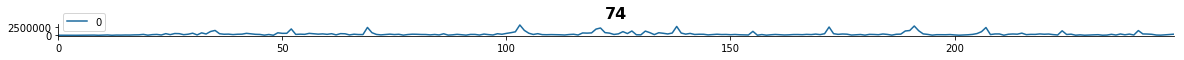

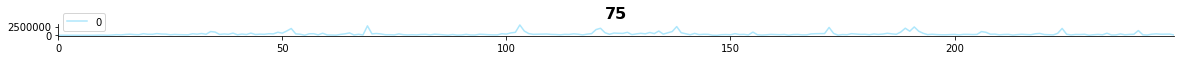

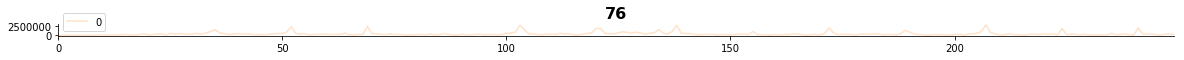

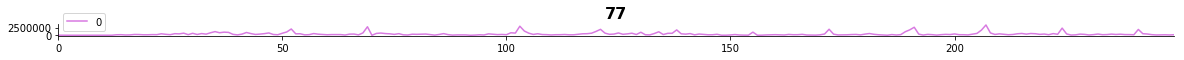

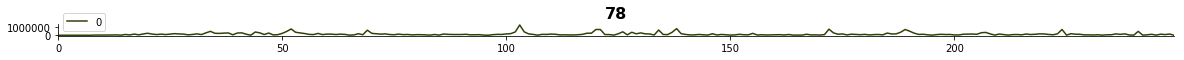

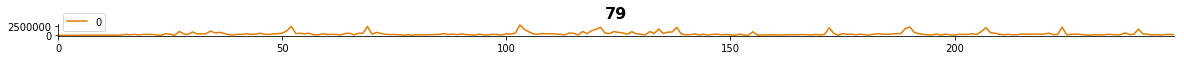

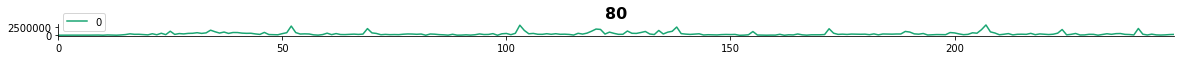

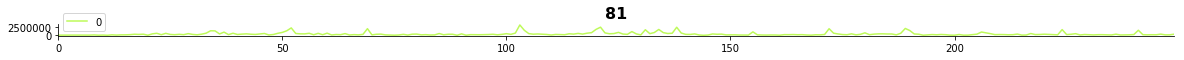

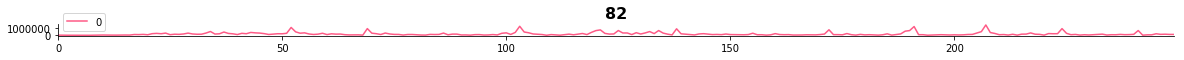

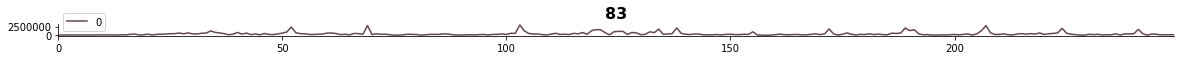

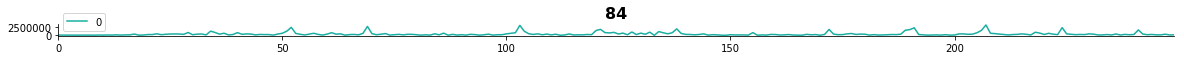

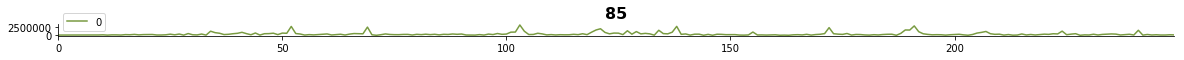

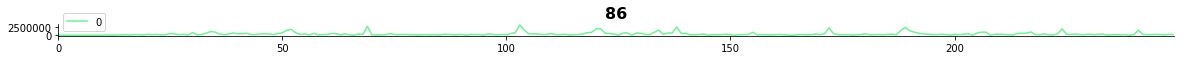

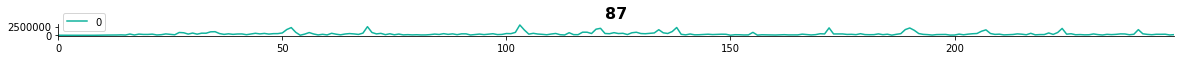

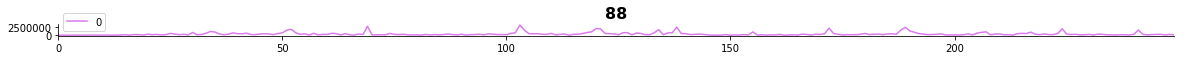

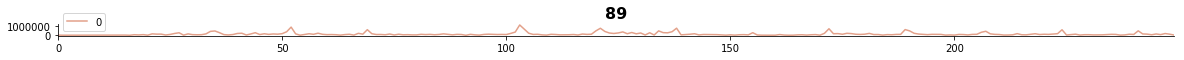

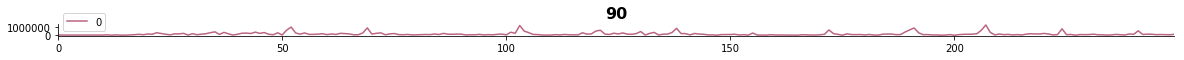

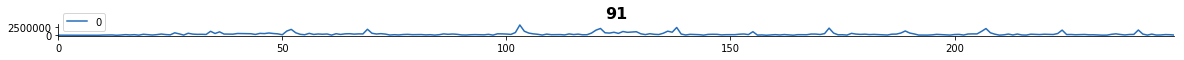

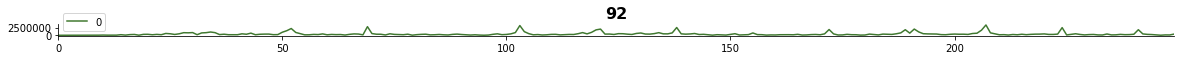

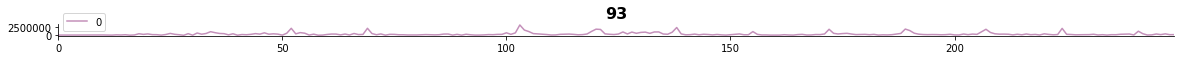

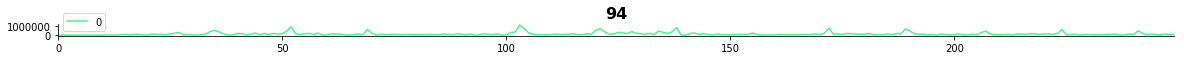

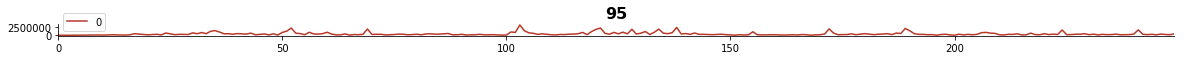

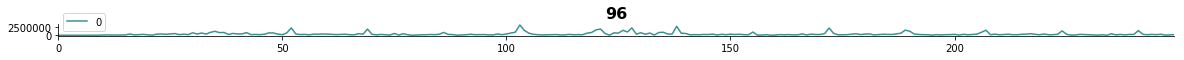

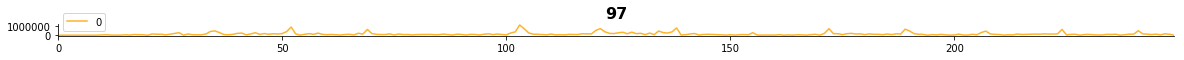

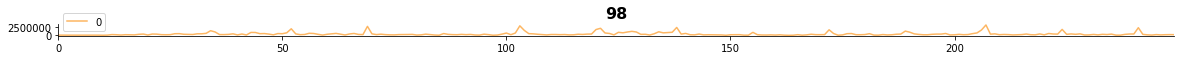

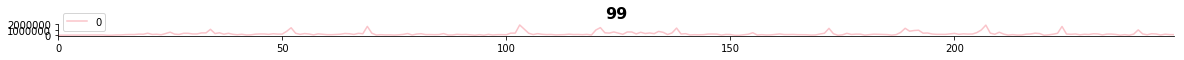

In [147]:
hf.plotfreq(subsets_real, 250, False, True, window = 101)

In [ ]:
small_sounds, small_files = createdict("small")

In [ ]:
plotsounds(small_sounds)

In [ ]:
plotspecs(small_sounds)

In [ ]:
plotfreq(small_sounds, 25000)

In [140]:
large_sounds, large_files = hf.createdict("large")

/anaconda3/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/anaconda3/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


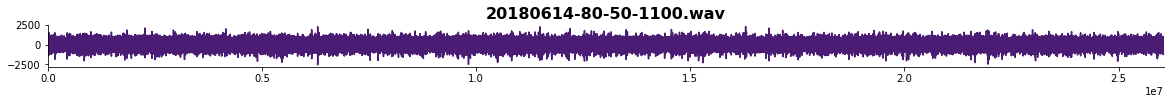

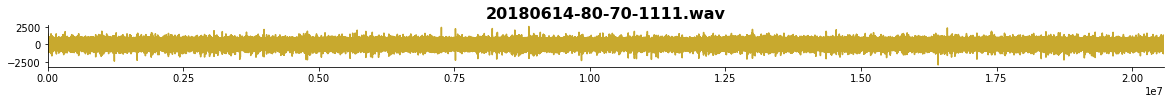

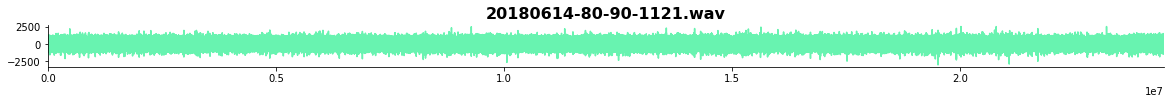

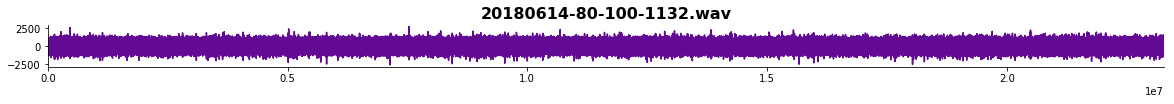

KeyboardInterrupt: 

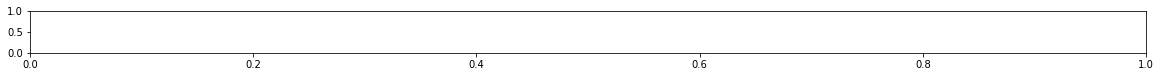

In [141]:
hf.plotsounds(large_sounds)

In [ ]:
hf.plotspecs(large_sounds)

In [ ]:
plotfreq(large_sounds, 25000)

In [ ]:
subsets_large = rand_crops(large_sounds['20180614-100-115-1010.wav'][1][0], 50000, 100)

In [ ]:
plotfreq(subsets_large, 250, False, True, window = 101)

In [ ]:
def tsplot2(y, name, lags = None, figsize = (12, 8)):
    # Examine ACF and PACF
    
    fig = plt.figure(figsize = figsize)
    
    # Set grid
    grid = (1, 2)
    acf_ax = plt.subplot2grid(grid, (0, 0))
    pacf_ax = plt.subplot2grid(grid, (0, 1))
    
    # Plot time series, acf, pacf and histogram
    smt.graphics.tsa.plot_acf(y, lags = lags, ax = acf_ax)
    smt.graphics.tsa.plot_pacf(y, lags = lags, ax = pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    
    return acf_ax, pacf_ax

In [ ]:
dic = real_sounds

for file in dic.keys():
    tsplot2(dic[file][1][0], name = file, lags = 45)

In [ ]:
expected_peaks = [2600, 5300]
threshold = [100, 100]


def run(data):
    freq, amp = peaklocs(data)
    return anomaly(expected_peaks, threshold, freq, amp)


def anomaly(expect, threshold, data, amp):
    anomaly = False
    diffs = []
    if len(expect) > len(data):
        data = np.append(data, np.zeros(len(expect) - len(data)))
    elif len(data) > len(expect):
        expect = np.append(expect, np.zeros(len(data) - len(expect)))
        threshold = np.append(threshold, np.zeros(len(data) - len(threshold)))

    for i, e in enumerate(expect):
        diffs.append(np.abs(data[i] - e))
        if data[i] - e > threshold[i]:
            anomaly = True

    vs = np.mean(diffs)
    if anomaly:
        print("Freq:", vs, data, amp)
    return vs, anomaly


def peaklocs(data):
    # transform into fequrency space
    N = int(len(data) / 2)
    T = 1.0 / 44100
    amp_trf = np.abs(np.fft.fft(data)[0:N])
    freq = np.linspace(0.0, 1.0 / (2.0 * T), N)
    # plt.plot(freq, amp_trf)
    # plt.show()

    # filter out noise and normalise amplitude to 1
    amp_smoothed = savgol_filter(amp_trf, 3001, 3)
    amp_smoothed_n = normalize(
        amp_smoothed.reshape(-1, 1), norm="max", axis=0
    ).flatten()
    # plt.plot(freq, amp_smoothed_n)
    # plt.show()

    # now find peaks
    # plt.plot(freq, amp_smoothed_n)
    peaks, _ = find_peaks(amp_smoothed_n.flatten(), width=200, prominence=0.05)
    # plt.plot(freq[peaks], amp_smoothed_n[peaks], "x")
    # plt.show()

    return freq[peaks], amp_smoothed_n[peaks]


if __name__ == "__main__":
    fs, data = wavfile.read("data/cavitation-2.wav")
    # plt.plot(data)
    # plt.show()
    freq, amp = peaklocs(data[0:150000])
    vs, predict = run(data[0:150000])
    print(vs, predict)
    # print(freq)

    fs, data = wavfile.read("data/cavitation-1.wav")
    # plt.plot(data)
    # plt.show()
    freq, amp = peaklocs(data[0:150000, 0])
    vs, predict = run(data[0:150000, 0])
    print(vs, predict)
    # print(freq)

In [ ]:
os.listdir("data")

In [ ]:
# Self labeled anomalies

labels = {}
labels[syn_files[0]] = None
labels[syn_files[0]] = (240000, 490000)
labels[syn_files[0]] = (240000, 490000)
labels[syn_files[0]] = (240000, 490000)